# MISSING ANNOTATIONS
# MISSING COMMENTS AND PROPER DOCUMENTATION
# MISSING TO REVIEW IMPORTED LIBRARIES

In [2]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Local modules
from src.data import get_data, split_data, remove_correlated_features

In [ ]:
# Load data from openML into a DataFrame
df = get_data()

## Exploratory Data Analysis

In [ ]:
df.shape

(76020, 370)

In [ ]:
df.dtypes.unique()

array([dtype('int64'), dtype('uint8'), dtype('float64'),
       CategoricalDtype(categories=['0.0', '1.0'], ordered=False, categories_dtype=object)],
      dtype=object)

In [ ]:
# Discover dataset's shape, data types and size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 370 entries, var3 to TARGET
dtypes: category(1), float64(115), int64(38), uint8(216)
memory usage: 104.5 MB


- There are 369 features and 76k rows. 
- All features are numeric, TARGET is categorical.

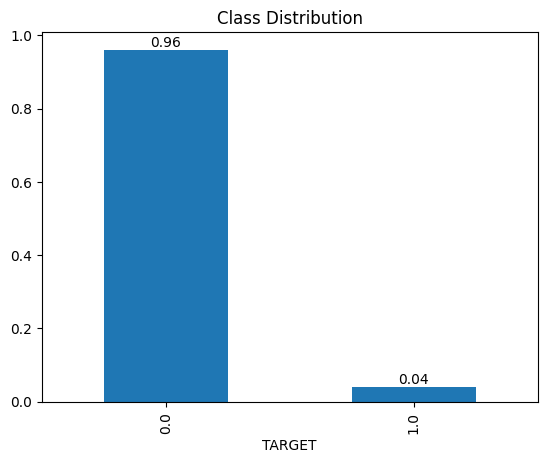

In [28]:
# Understand distribution in the TARGET column
ax = df.TARGET.value_counts(normalize=True).plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=0)
plt.title('Class Distribution')
plt.show()

In [29]:
# Check missing values
df.isna().sum().sort_values(ascending=False).head()

var3                       0
imp_trasp_var17_in_ult1    0
ind_var7_emit_ult1         0
imp_venta_var44_ult1       0
imp_venta_var44_hace3      0
dtype: int64

In [30]:
# There are too many features, there is a high probability of not all being useful - Many correlated values
# Set a threshold of absolute correlation == 0.9, anything above that is flagged
corr = df.corr(numeric_only=True)

high_corr = (corr.abs() > 0.9) & (corr.abs() < 1)
high_corr.sum().sort_values(ascending=False).head(20)

saldo_medio_var13_medio_hace2    8
saldo_medio_var13_medio_ult3     8
saldo_medio_var17_ult1           6
saldo_var34                      6
saldo_var31                      6
saldo_var17                      6
saldo_var29                      6
saldo_medio_var17_hace2          6
saldo_medio_var17_ult3           6
saldo_medio_var17_hace3          6
imp_aport_var17_hace3            6
saldo_var6                       6
ind_var26_cte                    5
ind_var1                         5
ind_var13_corto_0                5
ind_var25_cte                    5
ind_var24                        5
num_op_var39_ult1                5
num_var24                        5
num_var13_medio_0                5
dtype: int64

In [31]:
# Since there are columns with multiple highly correlated values, we can keep only one for each pair and reduce the non-important ones

df_reduced, dropped = remove_correlated_features(df)
print(f"Dropped {len(dropped)} correlated features.")
print(df.shape, "→", df_reduced.shape)

Dropped 166 correlated features.
(76020, 370) → (76020, 204)


## Data split

In [ ]:
# Split the data in 60/20/20 using sklearn's built-in function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_reduced)

## Model selection

This is a classification problem, so 4 different models are trained and compared to find the best performing one.

### Logistic Regression - Ridge

In [ ]:
# There are many numerical columns with different scales
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Used LogisticRegressionCV model because it is more advanced than its original version 
# Set multiple regularization values so it can pick the best one.
# Defined 5 folds (cv) to find the sweet spot of accuracy-performance
model = LogisticRegressionCV(
    Cs=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    cv=5,
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

,Cs,"[0.0001, 0.001, ...]"
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,'roc_auc'
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,-1


In [ ]:
# 
y_pred = model.predict_proba(X_val_scaled)[:,1]
auc_lr_val = roc_auc_score(y_val, y_pred)

In [41]:
y_pred = model.predict_proba(X_test_scaled)[:,1]
auc_lr_test = roc_auc_score(y_test, y_pred)

## Decision Trees

In [42]:
param_grid = {
    'max_depth': [5, 6, 7, 8],
    'min_samples_leaf': [100, 200, 300, 400, 500, 600],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=666)

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
print("Best params:", grid_dt.best_params_)
print("Best AUC:", grid_dt.best_score_)

Best params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 400, 'min_samples_split': 2}
Best AUC: 0.8232692312773786


In [44]:
y_pred = grid_dt.predict_proba(X_val)[:,1]
auc_dt_val = roc_auc_score(y_val, y_pred)

In [45]:
y_pred = grid_dt.predict_proba(X_test)[:,1]
auc_dt_test = roc_auc_score(y_test, y_pred)

## Random Forest

In [46]:
param_dist = {
    "n_estimators": range(10, 201, 10),
    "max_depth": [5, 10, 15, None],
    "min_samples_leaf": range(10, 201, 10),
    "min_samples_split": range(10, 201, 10)
}

rf = RandomForestClassifier()

search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=80, cv=3, scoring="roc_auc",
    n_jobs=-1, random_state=666, verbose=1
)
search_rf.fit(X_train, y_train)
print("Best params:", search_rf.best_params_)
print("Best AUC:", search_rf.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best params: {'n_estimators': 70, 'min_samples_split': 90, 'min_samples_leaf': 10, 'max_depth': 15}
Best AUC: 0.8199107329946784


In [52]:
y_pred = search_rf.predict_proba(X_val)[:,1]
auc_rf_val = roc_auc_score(y_val, y_pred)

In [53]:
y_pred = search_rf.predict_proba(X_test)[:,1]
auc_rf_test = roc_auc_score(y_test, y_pred)

## XGBoost

In [ ]:
y_train = y_train.astype(float).astype(int)
y_val = y_val.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

param_dist = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 150, 200, 250, 300, 350, 400],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3, 4, 5, 6]
}

xgb = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric='auc',
    random_state=666
)

search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=80,
    cv=5,
    n_jobs=-1,
    random_state=666,
    verbose=1
)

search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [55]:
print("Best params:", search_xgb.best_params_)
print("Best AUC:", search_xgb.best_score_)

Best params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best AUC: 0.9605805555938076


In [61]:
y_pred = search_xgb.predict_proba(X_val)[:,1]
auc_xgb_val = roc_auc_score(y_val, y_pred)

In [62]:
y_pred = search_xgb.predict_proba(X_test)[:,1]
auc_xgb_test = roc_auc_score(y_test, y_pred)

## Selecting the best model

In [84]:
auc_scores = pd.DataFrame(
    [
        ['LogisticRegressionCV', auc_lr_val, auc_lr_test],
        ['DecisionTreeClassifier', auc_dt_val, auc_dt_test],
        ['RandomForestClassifier', auc_rf_val, auc_rf_test],
        ['XGBClassifier', auc_xgb_val, auc_xgb_test]
    ],
    columns = ['model', 'val_auc', 'test_auc']
)

auc_scores['var'] = auc_scores['test_auc'] - auc_scores['val_auc']
auc_scores['Rank'] = auc_scores['test_auc'].rank(ascending=False)

auc_scores = auc_scores.round(3)

auc_scores.sort_values(by='Rank')

,model,val_auc,test_auc,var,Rank
3,XGBClassifier,0.834,0.844,0.010,1.0
1,DecisionTreeClassifier,0.813,0.829,0.015,2.0
2,RandomForestClassifier,0.820,0.827,0.007,3.0
0,LogisticRegressionCV,0.794,0.804,0.010,4.0


## Best model validation

In [83]:
best_xgb = search_xgb.best_estimator_

final_xgb = best_xgb.fit(pd.concat([X_train, X_val]),
                       pd.concat([y_train, y_val]))

y_test_pred = final_xgb.predict_proba(X_test)[:,1]

print('Final test AUC:', roc_auc_score(y_test, y_test_pred))

Final test AUC: 0.8473568450323785


In [ ]:
prec, rec, thr = precision_recall_curve(y_test, y_test_pred)
f1_scores = 2 * prec * rec / (prec + rec)

best_thr = thr[f1_scores.argmax()]
print(f"Optimal threshold: {best_thr:.3f}")

Optimal threshold: 0.129


In [144]:
y_pred = (y_test_pred > best_thr).astype(int)

confusion_matrix(y_test, y_pred)

array([[13378,  1224],
       [  298,   304]])

In [ ]:
print("PR-AUC:", average_precision_score(y_test, y_test_pred))

PR-AUC: 0.19420206107915444


We are predicting dissatisfied customers, so it is important to find a high number of true positives and assume the risk of higher false positives.

In [149]:
fi = pd.Series(final_xgb.feature_importances_).sort_values(ascending=False)
print(fi.head(10), fi.head(10).sum())

43    0.176799
93    0.069331
71    0.047571
1     0.047141
70    0.033037
54    0.028753
42    0.024184
23    0.022635
10    0.018262
25    0.017696
dtype: float32 0.48540905
